# Visualizing the results of the model selection

## Initialization

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dmml_project.model_selection.load_results import load_results, get_results_indices, model_name_from_index, index_from_model_name, BEAUTIFUL_NAMES
from dmml_project import PROJECT_ROOT, PAPER_IMAGES, PAPER_TABLES, PAPER_DYNAMIC
from dmml_project.utils import dataframe_to_latex, best_models_to_latex
from scipy.stats import wilcoxon

search_results = load_results()
results_indices = get_results_indices(search_results)

Skipping neural_network as no search results were found
Skipping decision_tree as no search results were found
Skipping random_forest as no search results were found
Skipping neural_network as no search results were found


## Model accuracy distribution (per model kind)

In [2]:

violin_plot_data = pd.DataFrame(columns=["f1", "model_kind", "generation"])
generations = ["First", "Second"]
for i, index in enumerate(results_indices):
    gen, model_kind, model_id = index
    result = search_results[gen][model_kind][model_id]
    f1s = np.array(result[1])
    mean = np.mean(f1s)
    std = np.std(f1s)
    for f1 in f1s:
        violin_plot_data.loc[len(violin_plot_data)] = [f1, BEAUTIFUL_NAMES[model_kind], generations[gen]]

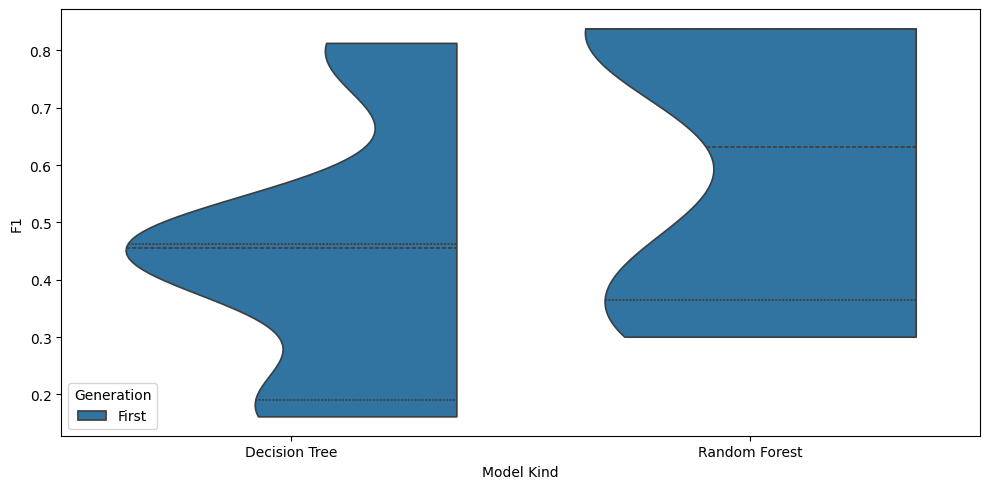

In [3]:
fig = plt.figure(figsize=(10, 5))
violin_plot_args = {
    "data": violin_plot_data, 
    "x": "model_kind", 
    "hue": "generation", 
    "split": True, 
    "gap": 0.1, 
    "density_norm": "width", 
    "inner": "quartile", 
    "cut": 0
}
sns.violinplot(y="f1", **violin_plot_args)
plt.ylabel("F1")
plt.xlabel("Model Kind")
plt.legend(title="Generation", loc='lower left')
plt.tight_layout()
plt.savefig(f"{PAPER_IMAGES}/accuracy_distribution.png")
plt.show()

## Model F1 distribution (per hyperparameter configuration)

In [4]:
kind_to_id = {kind: id for id, kind in enumerate(BEAUTIFUL_NAMES.keys())}
violin_plot_data = [[pd.DataFrame(columns=["f1", "model_kind", "hyperparameters"]) for _ in range(len(BEAUTIFUL_NAMES))] for _ in range(len(search_results))]
for i, index in enumerate(results_indices):
    gen, model_kind, model_id = index
    result = search_results[gen][model_kind][model_id]
    for j, accuracy in enumerate(result[1]):
            hyperparameters_name = f"{index[2]}"
            violin_plot_data[gen][kind_to_id[model_kind]].loc[len(violin_plot_data[gen][kind_to_id[model_kind]])] = [accuracy, BEAUTIFUL_NAMES[model_kind], hyperparameters_name]        

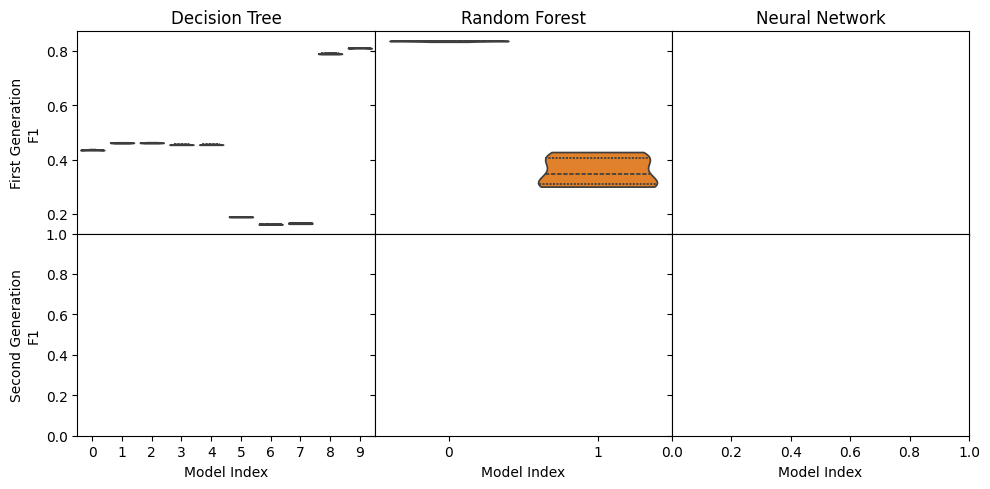

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharey="row", sharex="col", gridspec_kw={"hspace": 0, "wspace": 0, })
violin_plot_args = {
    "x": "hyperparameters", 
    "y": "f1",
    "hue": "hyperparameters", 
    "density_norm": "width", 
    "inner": "quartiles", 
    "cut": 0
}
for i, (_, model_kind) in enumerate(BEAUTIFUL_NAMES.items()):    
    axs[0,i].set_title(model_kind)
    sns.violinplot(data=violin_plot_data[0][i], ax=axs[0,i], **violin_plot_args)
    axs[0,i].set_xlabel(None)
    if i == 0:
        axs[0,i].set_ylabel("First Generation\nF1")
    else:
        axs[0,i].set_ylabel(None)
    sns.violinplot(data=violin_plot_data[1][i], ax=axs[1,i], **violin_plot_args)
    if i == 0:
        axs[1,i].set_ylabel("Second Generation\nF1")
    else:
        axs[1,i].set_ylabel(None)
    axs[1,i].set_xlabel("Model Index")
plt.tight_layout()
plt.savefig(f"{PAPER_IMAGES}/model_selection.png")
plt.show()

## Best model by accuracy per model kind

In [6]:
best_results = {}
for i, index in enumerate(results_indices):
    gen, model_kind, model_id = index
    result = search_results[gen][model_kind][model_id]
    accuracies = result[1]
    mean = np.mean(accuracies)
    if model_kind not in best_results or mean > best_results[model_kind][1]:
        best_results[model_kind] = (index, mean)

for model_kind, (index, mean) in best_results.items():
    print(f"Best {BEAUTIFUL_NAMES[model_kind]}: {model_name_from_index(index)} with mean F1 {mean*100:.2f}%")
    
table = pd.DataFrame(columns=["Model Name", "Mean F1"])
for model_kind, (index, mean) in best_results.items():
    table.loc[len(table)] = [model_name_from_index(index), mean]

dataframe_to_latex(
    table, 
    caption="Best models for each kind", 
    label="tab:best_model_per_kind", 
    formatters={
        "Model Name": lambda x: f"\\texttt{{{x.replace("_", "\\_")}}}",
        "Mean F1": lambda x: f"{x*100:.2f}\\%"
    },
    columns_format="|X|r|",
    file=f"{PAPER_TABLES}/best_model_per_kind.tex"
)

for model_name in table["Model Name"]:
    gen, model_kind, model_id = index_from_model_name(model_name)
    hypers = search_results[gen][model_kind][model_id][0]
    model_table = pd.DataFrame(columns=["Hyperparameter", "Value"])
    for key, value in hypers.items():
        model_table.loc[len(model_table)] = [key, value]
    dataframe_to_latex(
        model_table, 
        caption=f"Hyperparameters used for model \\texttt{{{model_name.replace("_", "\\_")}}}.", 
        label=f"tab:hyperparameters_best_{model_kind}", 
        formatters={
            "Hyperparameter": lambda x: f"\\texttt{{{x.replace('_', '\\_')}}}",
            "Value": lambda x: str(x).replace("_", "\\_")
        },
        columns_format="|X|l|",
        file=f"{PAPER_TABLES}/hyperparameters_best_{model_kind}.tex"
    )

Best Decision Tree: decision_tree-G0-9 with mean F1 81.08%
Best Random Forest: random_forest-G0-0 with mean F1 83.65%


## Best models by F1 (with Wilcoxon test)

Use the Wilcoxon test to find the best models that are statistically different from the others.

In [7]:
import warnings

warnings.filterwarnings("ignore")

p_matrix = np.ones((len(results_indices), len(results_indices)))

def model_name_from_index(index: tuple[int, str, int]) -> str:
    gen, model_kind, i = index
    return f"{model_kind}-G{gen}-{i}"

for i in range(len(results_indices)):
    for j in range(i+1, len(results_indices)):
        gen1, model_kind1, i1 = results_indices[i]
        gen2, model_kind2, i2 = results_indices[j]
        accuracies1 = search_results[gen1][model_kind1][i1][1]
        accuracies2 = search_results[gen2][model_kind2][i2][1]
        _, p = wilcoxon(accuracies1, accuracies2, zero_method="zsplit")
        p_matrix[i, j] = p
        p_matrix[j, i] = p
        #print(f"{model_kind1}-G{gen1}-{i1} and {model_kind2}-G{gen2}-{i2}: p={p:.2f}")
        
best_model_index = None
best_f1 = 0
for i, index in enumerate(results_indices):
    gen, model_kind, idx = index
    f1 = np.mean(search_results[gen][model_kind][idx][1])
    if f1 > best_f1:
        best_f1 = f1
        best_model_index = i
similar_models = []
print(f"Best model: {model_name_from_index(results_indices[best_model_index])} ({best_f1*100:.2f}%)")
for i, index in enumerate(results_indices):
    gen, model_kind, idx = index
    if i == best_model_index:
        continue
    p = p_matrix[best_model_index, i]
    accuracy = np.mean(search_results[gen][model_kind][idx][1])
    if p >= 0.05:
        print(f"{model_name_from_index(index)} ({accuracy*100:.2f}%) is similar to the best (p={p:.3f})")
        similar_models.append(index)

table = pd.DataFrame(columns=["Model", "Mean F1"])
table.loc[len(table)] = [model_name_from_index(results_indices[best_model_index]), best_f1]
for index in similar_models:
    gen, model_kind, idx = index
    accuracy = np.mean(search_results[gen][model_kind][idx][1])
    table.loc[len(table)] = [model_name_from_index(index), accuracy]
table = table.sort_values("Mean F1", ascending=False) 

dataframe_to_latex(
    table, 
    "Best model (first row) and models not significantly different from the best model.",
    "tab:best_models",
    columns_format="|X|r|",
    formatters = {
        "Model": lambda x: f"\\texttt{{{x.replace("_","\\_")}}}",
        "Mean F1": lambda x: f"{x*100:.2f}\\%",
    },
    file=f"{PAPER_TABLES}/best_models.tex"
)

if len(similar_models) == 0:
    similar_models_text = \
"""every model was significantly different
($p>0.05$) from the best model.
"""

else:
    similar_models_text = \
"""some models were not significantly different 
($p>0.05$) from the best model and they 
are listed in \\autoref{tab:best_models}.

\\input{tables/best_models}
"""
    
with open(f"{PAPER_DYNAMIC}/similar_models.tex", "w") as f:
    f.write(similar_models_text)
        
#best_models_to_latex(best_model_index, best_accuracy, results_indices, similar_models, search_results)


Best model: random_forest-G0-0 (83.65%)


Plot a heatmap with the p-values of the Wilcoxon test.

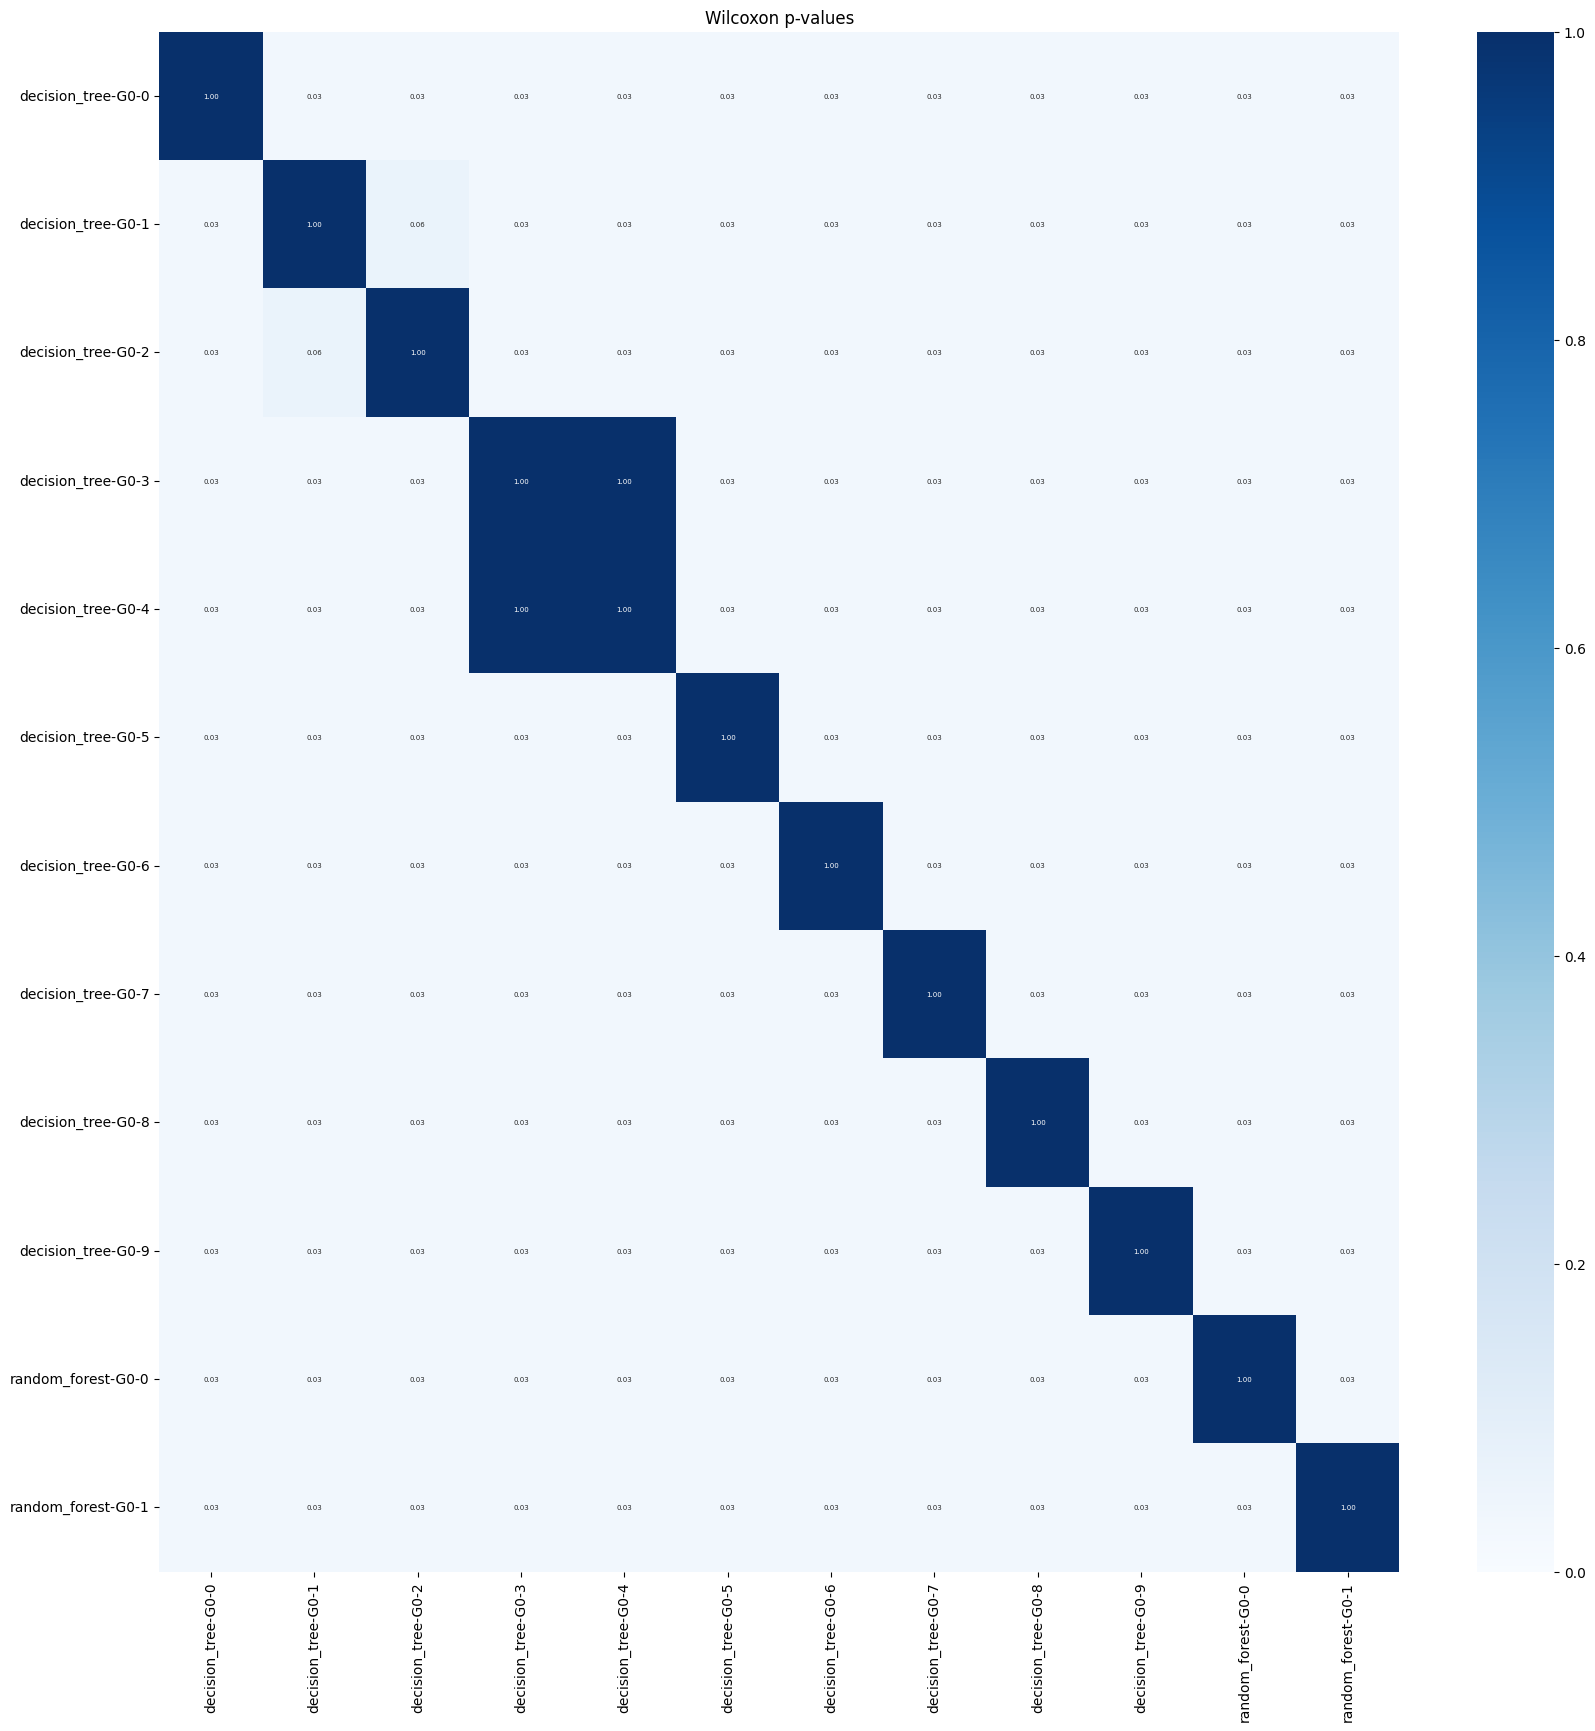

In [8]:
plt.figure(figsize=(20, 20))
plt.title("Wilcoxon p-values")
model_names = [model_name_from_index(i) for i in results_indices]
sns.heatmap(p_matrix, cmap="Blues", annot=True, xticklabels=model_names, yticklabels=model_names, fmt=".2f", annot_kws={"size": 5}, vmin=0, vmax=1)
plt.show()